In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
source("tests.R")
source("cleanup.R")
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [6]:
dataset <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)
dataset <- slice(dataset, 1:122)
dataset

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_character(),
  Temperature = col_character(),
  RH = col_character(),
  Ws = col_character(),
  Rain = col_character(),
  FFMC = col_character(),
  DMC = col_character(),
  DC = col_character(),
  ISI = col_character(),
  BUI = col_character(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“2 parsing failures.
row col   expected     actual                                                                                                       file
123  -- 14 columns 1 columns  'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
168  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv'
”


day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire
06,06,2012,31,67,14,0,82.6,5.8,22.2,3.1,7,2.5,fire
07,06,2012,33,54,13,0,88.2,9.9,30.5,6.4,10.9,7.2,fire
08,06,2012,30,73,15,0,86.6,12.1,38.3,5.6,13.5,7.1,fire
09,06,2012,25,88,13,0.2,52.9,7.9,38.8,0.4,10.5,0.3,not fire


day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire
07,06,2012,33,54,13,0,88.2,9.9,30.5,6.4,10.9,7.2,fire
08,06,2012,30,73,15,0,86.6,12.1,38.3,5.6,13.5,7.1,fire
10,06,2012,28,79,12,0,73.2,9.5,46.3,1.3,12.6,0.9,not fire
12,06,2012,26,81,19,0,84,13.8,61.4,4.8,17.7,7.1,fire


`summarise()` ungrouping output (override with `.groups` argument)



Classes,n
<chr>,<int>
fire,42
not fire,45


Predictor,Mean
<chr>,<dbl>
Temperature,31.149425
Ws,15.942529
FWI,5.733333


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


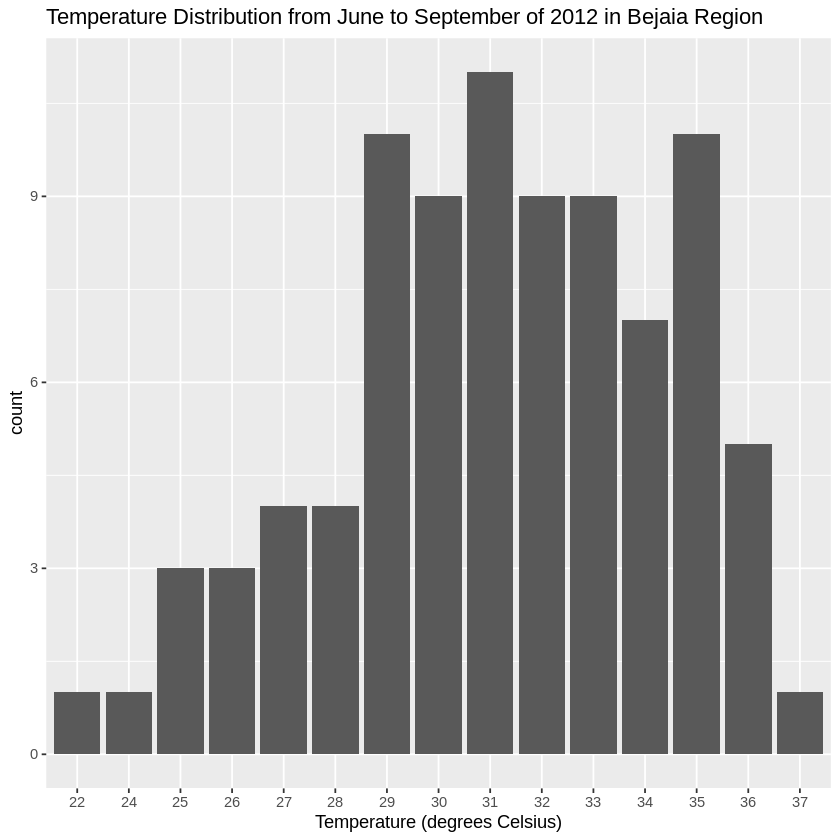

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


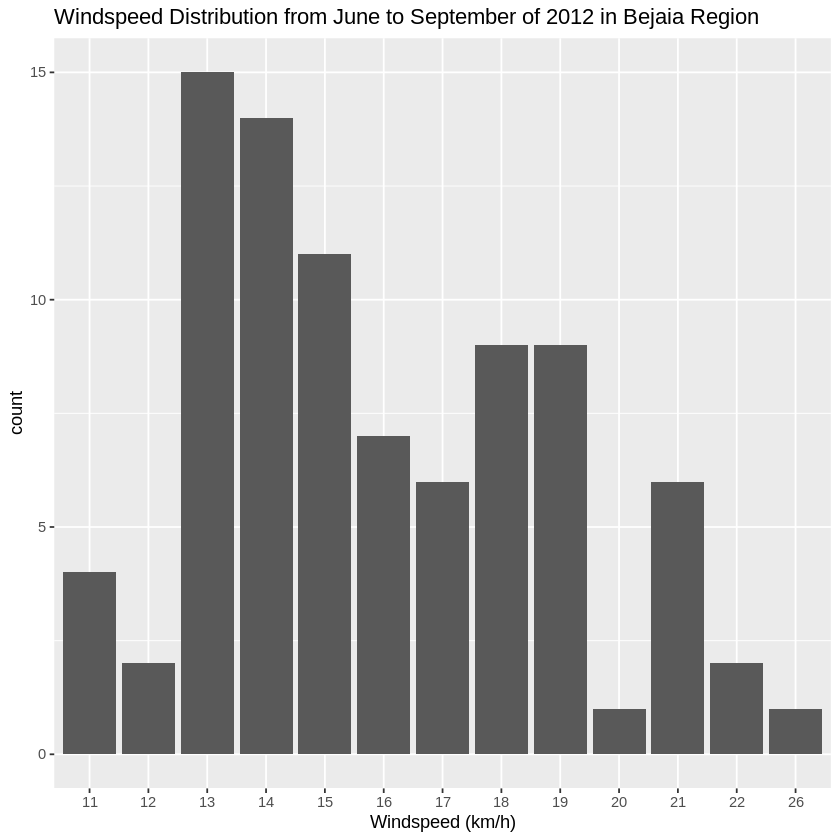

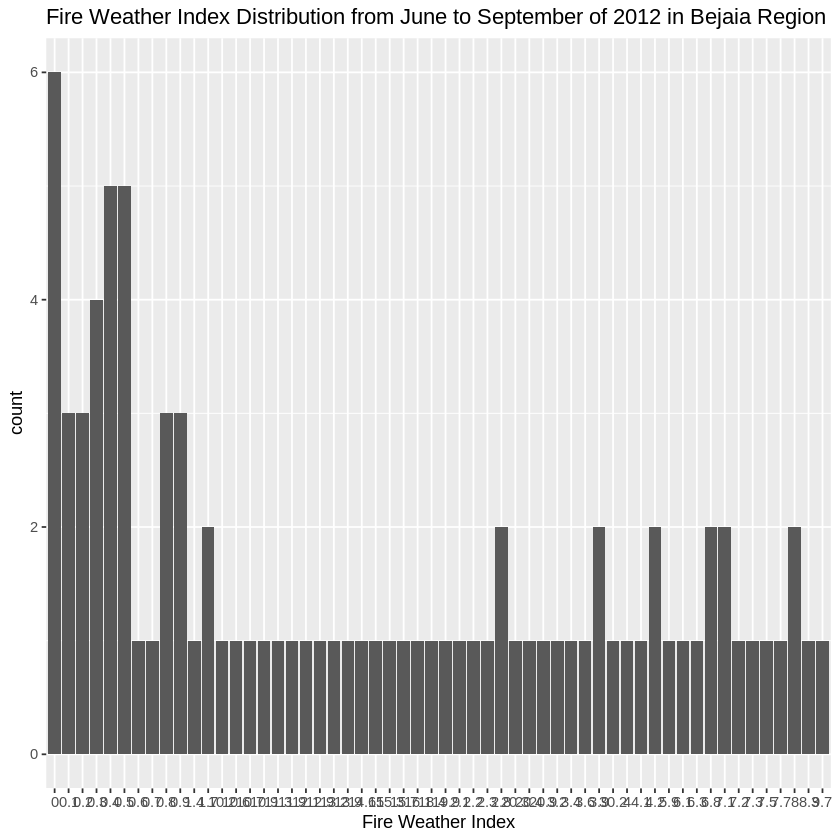

In [28]:
factored_dataset <- mutate(dataset, Classes = as_factor(Classes))


set.seed(1)
fire_split <- initial_split(dataset, prop = 0.7, strata = Classes)
fire_training <- training(fire_split)
fire_test <- testing(fire_split)

fire_training

class_counts <- fire_training %>%
    group_by(Classes) %>%
    summarize(n = n())
class_counts

predictor_means <- fire_training %>%
    select(Temperature, Ws, FWI) %>%
    mutate(across(Temperature:FWI, as.double)) %>%
    select(Temperature:FWI) %>%
    map_dfr(mean) %>%
    pivot_longer(cols = Temperature:FWI,
                 names_to = "Predictor",
                 values_to = "Mean")
predictor_means

temp_dstn_plot <- fire_training %>%
    ggplot(aes(x = Temperature)) + 
    geom_histogram(stat = "count") +
    labs(x = "Temperature (degrees Celsius)") + 
    ggtitle("Temperature Distribution from June to September of 2012 in Bejaia Region")
temp_dstn_plot

ws_dstn_plot <- fire_training %>%
    ggplot(aes(x = Ws)) + 
    geom_histogram(stat = "count") +
    labs(x = "Windspeed (km/h)") + 
    ggtitle("Windspeed Distribution from June to September of 2012 in Bejaia Region")
ws_dstn_plot

FWI_dstn_plot <- fire_training %>%
    ggplot(aes(x = FWI)) + 
    geom_histogram(stat = "count") +
    labs(x = "Fire Weather Index") + 
    ggtitle("Fire Weather Index Distribution from June to September of 2012 in Bejaia Region")
FWI_dstn_plot